In [39]:
import sklearn
import sklearn.datasets
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

import numpy as np

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_iris, load_diabetes

from nonconformist.base import OobClassifierAdapter, OobRegressorAdapter
from nonconformist.icp import OobCpClassifier, OobCpRegressor
from nonconformist.nc import ClassifierNc, RegressorNc

from nonconformist.evaluation import cross_val_score
from nonconformist.evaluation import ClassIcpCvHelper, RegIcpCvHelper
from nonconformist.evaluation import class_avg_c, class_mean_errors
from nonconformist.evaluation import reg_mean_errors, reg_median_size

In [3]:
# Load data
boston = sklearn.datasets.load_boston()
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR'])

print(boston['DESCR'])

In [4]:
boston['data']

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [5]:
boston['target']

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
       19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
       20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
       23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
       33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
       21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
       20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
       23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
       15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21

In [6]:
pd.DataFrame(data=boston['data'], columns=boston['feature_names']).describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


import sklearn.utils as ut
print(ut.Bunch.__doc__)

MSE: 6.7013


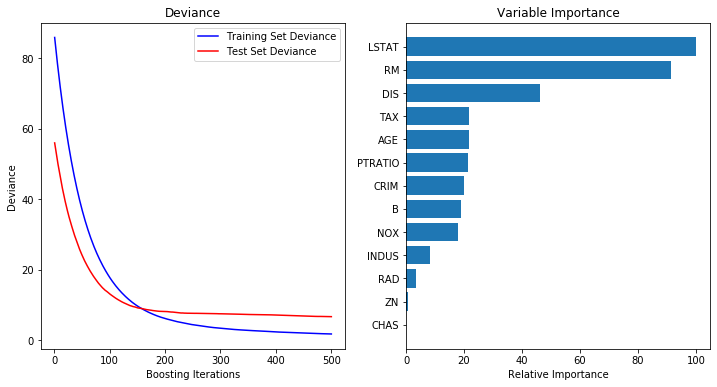

In [7]:



# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [44]:
rf = RandomForestRegressor(n_estimators=100, bootstrap=True, oob_score=True)

In [28]:
predicted = cross_val_predict(rf, boston.data, boston.target, cv=boston.target.size)

In [29]:
import seaborn as sns

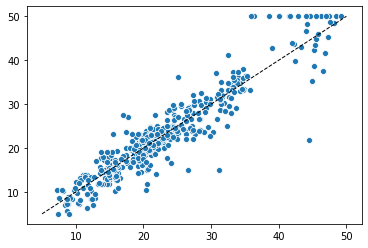

In [30]:
ax = sns.scatterplot(predicted, boston.target)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)

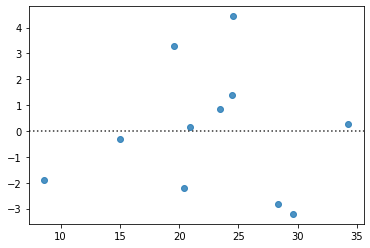

In [33]:
sns.residplot(predicted[::50], boston.target[::50])

## Build a conformal regressor

In [26]:
icp = OobCpRegressor(RegressorNc(OobRegressorAdapter(RandomForestRegressor(n_estimators=100, bootstrap=True, oob_score=True))))
icp_cv = RegIcpCvHelper(icp)

scores = cross_val_score(icp_cv,
                         boston.data,
                         boston.target,
                         iterations=10,
                         folds=10,
                         scoring_funcs=[reg_mean_errors, reg_median_size],
                         significance_levels=[0.05, 0.1, 0.2],
                        verbose=True)


print('Absolute error regression: boston')
scores = scores.drop(['fold', 'iter'], axis=1)
print(scores.groupby(['significance']).mean())

iter 10/10 fold 10/10Absolute error regression: boston
              reg_mean_errors  reg_median_size
significance                                  
0.05                 0.044506        13.996815
0.10                 0.095498         9.828898
0.20                 0.196478         6.792083


In [45]:
cp_predicts = []
cv = KFold(n_splits=boston.target.size)
x = boston.data
y = boston.target
for i, (train_id, test_id) in enumerate(cv.split(boston.data)):
    r = clone(rf)
    r.fit(x[train_id], y[train_id])
    y_pred = r.predict(x[test_id])
    m = clone(icp)
    m.fit(x[train_id], y[train_id])
    cp_predicts.append((m.predict(x[test_id], significance=0.05), y[test_id], y_pred))

In [47]:
results = pd.DataFrame(data=cp_predicts, columns=['cp_interval', 'y_orig', 'y_pred'])
results

,cp_interval,y_orig,y_pred
0,"[[22.550749999999965, 35.31325000000005]]",[24.0],[28.334999999999994]
1,"[[15.92592820512822, 29.115671794871812]]",[21.6],[22.286000000000012]
2,"[[28.032146236559093, 41.0622537634408]]",[34.7],[33.889]
3,"[[28.794052830188626, 41.20914716981127]]",[33.4],[34.56800000000002]
4,"[[27.994841666666595, 40.542758333333275]]",[36.2],[34.63000000000002]
...,...,...,...
501,"[[18.0556842105263, 30.068315789473694]]",[22.4],[23.94599999999999]
502,"[[12.01775, 25.190250000000013]]",[20.6],[18.696000000000012]
503,"[[21.076296629213463, 35.190903370786515]]",[23.9],[27.766999999999985]
504,"[[19.681375609756074, 32.55942439024388]]",[22.0],[26.097000000000012]


In [49]:
rnd_ids = np.random.permutation(len(results))

In [53]:
excerpt = results.iloc[rnd_ids[0:25]]
excerpt

,cp_interval,y_orig,y_pred
297,"[[14.690399999999984, 27.590399999999995]]",[20.3],[20.48900000000002]
285,"[[14.833258333333276, 29.060341666666687]]",[22.0],[22.418000000000003]
68,"[[13.113257142857123, 25.82754285714286]]",[17.4],[19.236]
453,"[[15.786145054945049, 28.076254945054952]]",[17.8],[21.916999999999984]
135,"[[10.69420674157298, 23.664993258427]]",[18.1],[17.248]
212,"[[14.785822222222198, 28.321377777777773]]",[22.4],[21.291]
259,"[[23.80570731707315, 36.24229268292682]]",[30.1],[30.249000000000002]
393,"[[7.76329361702126, 21.933506382978706]]",[13.8],[14.99500000000001]
410,"[[20.712687640449438, 32.93291235955056]]",[15.0],[26.599000000000025]
381,"[[4.235372477064198, 17.501427522935785]]",[10.9],[11.185000000000004]


array([14.6904, 27.5904])

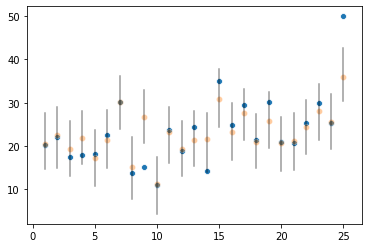

In [88]:
ax = sns.scatterplot(np.linspace(1, 25, 25), excerpt['y_orig'].to_numpy().astype(float))
ax = sns.scatterplot(np.linspace(1, 25, 25), excerpt['y_pred'].to_numpy().astype(float), alpha=0.4, ax=ax)
for i in range(1, 25+1):
    row = excerpt.iloc[i-1]
    yrange = row['cp_interval'][0]
    plt.plot((i, i), yrange, 'k-', alpha=0.4)
#    plt.axvline(x=i,
#               ymin=yrange[0],
#               ymax=yrange[1],
#               linewidth=1,
#               color='k')
plt.show()

In [74]:
excerpt['y_orig'].to_numpy().astype(float)

array([20.3, 22. , 17.4, 17.8, 18.1, 22.4, 30.1, 13.8, 15. , 10.9, 23.6,
       18.8, 24.3, 14.1, 35.1, 24.8, 29.4, 21.4, 30.1, 20.8, 20.6, 25.3,
       29.9, 25.2, 50. ])

In [81]:
excerpt.iloc[0]['cp_interval'][0]

array([14.6904, 27.5904])

In [ ]:
plt.plot